# Strategy Description: Bollinger Band Mean Reversion (CAD)

### 1. Executive Summary
This strategy employs a classic **Mean Reversion** approach applied to the Canadian Dollar (CAD).

The core concept relies on **Bollinger Bands** to identify statistically extreme price levels. By defining overbought and oversold conditions as deviations of 2 standard deviations ($\sigma$) from the moving average, the strategy seeks to capitalize on the price's tendency to revert to its central tendency (the mean) after significant extensions.

### 2. Investment Universe & Specifications
* **Asset:** Canadian Dollar (CAD)
    * Point Value: 100,000 (Standard Lot)
    * Transaction Cost: $5.0 per trade
* **Data Frequency:** 5-minute bars (Intraday)

### 3. Methodology

#### A. Indicator Construction (Bollinger Bands)
The strategy utilizes standard Bollinger Bands to measure volatility and relative price levels dynamically.
* **Central Tendency (Basis):** Simple Moving Average (SMA) of the Close price.
    * Window: 20 bars.
* **Volatility Metric:** Rolling Standard Deviation ($\sigma$) of the Close price (same window).

#### B. Dynamic Thresholds -> Advantages of this approach
[Rationale] Unlike fixed price thresholds, Bollinger Bands automatically adjust to market volatility.
* **Band Expansion:** During high volatility, the bands widen, requiring a larger price move to trigger a signal. This inherently filters out noise during turbulent periods.
* **Band Contraction:** During low volatility, the bands narrow, allowing the strategy to capture smaller revertive moves when the market is quiet.
* **Upper Band:** $MA + (2.0 \times \sigma)$
* **Lower Band:** $MA - (2.0 \times \sigma)$

### 4. Trading Logic

The strategy operates on a "Touch" basis for entries and a "Mean Return" basis for exits.

* **Entry Signals (Counter-Trend):**
    * **Short Signal:** If Price $\ge$ Upper Band ($+2\sigma$) $\rightarrow$ **Sell CAD**.
        * *Logic:* Price is statistically overextended to the upside (Overbought).
    * **Long Signal:** If Price $\le$ Lower Band ($-2\sigma$) $\rightarrow$ **Buy CAD**.
        * *Logic:* Price is statistically overextended to the downside (Oversold).

* **Exit Signals (Mean Reversion):**
    * Positions are closed when the price touches or crosses the **Central Moving Average (MA)**.
    * *Logic:* The statistical anomaly has normalized.

* **Constraints:**
    * Max Position: 1 Unit Long or 1 Unit Short.
    * **Out-of-Sample (OOS):** Trading is strictly disabled during OOS periods.

### 5. Risk Management
* **Volatility Adaptation:** The use of standard deviation ensures that entry criteria become stricter during turbulent market phases, naturally reducing trade frequency during unpredictable spikes.
* **Conservative Exit:** Exiting at the Mean (rather than waiting for the opposite band) secures profits earlier and reduces the duration of exposure to market risk.

Calculating Bollinger Bands (Window: 96, Continuous)...
Data Ready: 75913 rows (Dropped 46717 initial NaN rows)
Simulating BB Mean Reversion (Window: 96, Sigma: 1.8)...
Total Trades Executed: 2301.0

 PERFORMANCE REPORT: Bollinger Band Mean Reversion (CAD)

[Text Output]
   Quarter  Gross SR    Net SR  Ann. Vol ($)   Gross CR    Net CR  Gross CumP&L   Net CumP&L  Trades (CAD)  Av. Trades      Stat
0  2023_Q1  1.293882 -0.078787   4703.985474   4.363696 -0.199723   1637.934362   -97.065638         347.0    5.257576 -0.000000
1  2023_Q3 -0.507221 -1.961099   4291.879403  -1.759489 -4.450091   -592.800448 -2237.800448         329.0    4.910448 -1.982399
2  2023_Q4  3.764662  1.789476   3142.479986  17.060634  6.196694   3212.793321  1472.793321         348.0    5.272727  0.499235
3  2024_Q2  1.321248 -1.085334   2658.901415   2.968788 -1.729304    935.647879  -744.352121         336.0    5.169231 -0.000000
4  2024_Q4  0.020692 -2.315692   2587.757280   0.038721 -3.383664     14.328943 -15

,Quarter,Gross SR,Net SR,Ann. Vol ($),Gross CR,Net CR,Gross CumP&L,Net CumP&L,Trades (CAD),Av. Trades,Stat
0,2023_Q1,1.29,-0.08,"$4,704",4.36,-0.20,"$1,638",$-97,347,5.3,-0.0000
1,2023_Q3,-0.51,-1.96,"$4,292",-1.76,-4.45,$-593,"$-2,238",329,4.9,-1.9824
2,2023_Q4,3.76,1.79,"$3,142",17.06,6.20,"$3,213","$1,473",348,5.3,0.4992
3,2024_Q2,1.32,-1.09,"$2,659",2.97,-1.73,$936,$-744,336,5.2,-0.0000
4,2024_Q4,0.02,-2.32,"$2,588",0.04,-3.38,$14,"$-1,546",312,4.8,-1.2261
5,2025_Q1,1.65,0.13,"$3,784",6.76,0.30,"$1,598",$128,294,4.7,-0.0000
6,2025_Q2,-1.18,-3.07,"$3,511",-2.03,-3.55,"$-1,104","$-2,779",335,5.2,-3.6471
7,TOTAL,-,-,"$3,598",-,-,"$5,702","$-5,803","2,301",5.0,-6.3564



 TOTAL RANKING SCORE: -6.3564


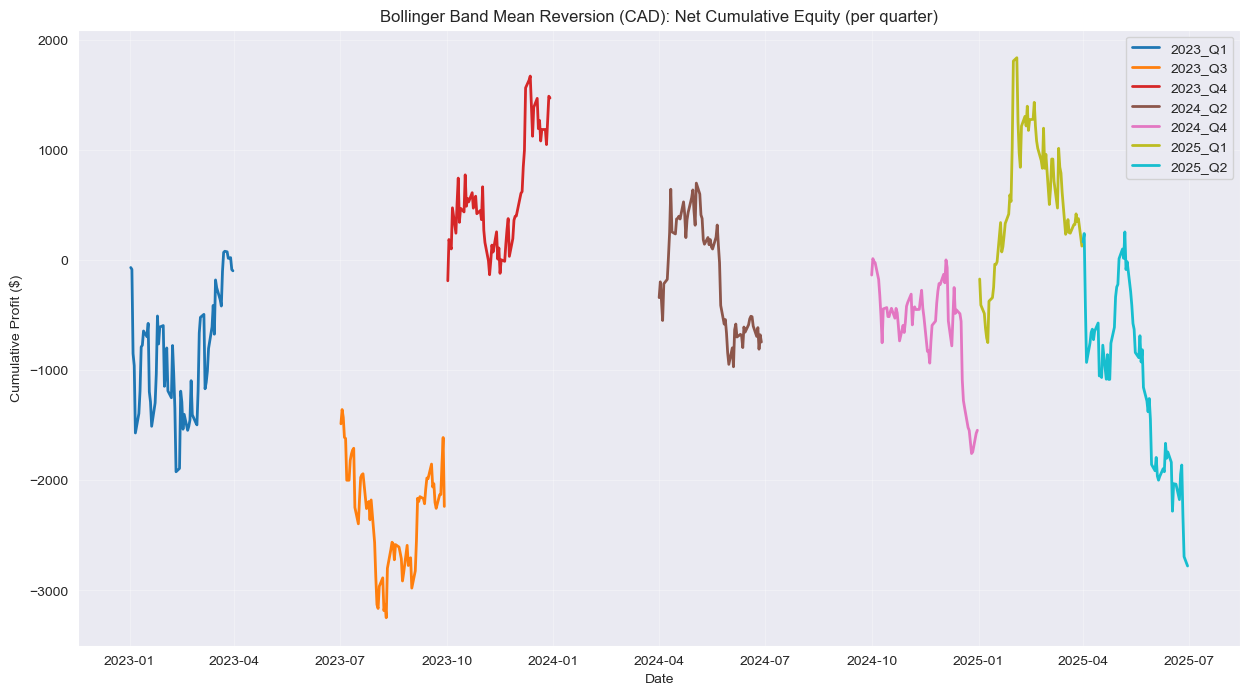

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

# Filter warnings for cleaner output
warnings.filterwarnings('ignore')


# ==========================================
# 1. Configuration
# ==========================================
class Config:
    # File Path (Same as reference)
    FILE_PATH = '../../preprocess/df_g2_processed.pkl'

    # Asset changed to CAD as requested
    ASSETS = ['CAD']

    # Contract Specifications
    # Assuming Standard Lot for CAD (100,000 units).
    # 1 pip (0.0001) move = $10. Cost set conservatively at $5 per trade.
    SPECS = {
        'CAD': {'point_val': 100000.0, 'cost': 5.0}
    }

    # --- Strategy Parameters (Bollinger Bands Mean Reversion) ---

    # [Correction] Window Size
    # 3000 is too large and causes data loss at the start of quarters.
    # Adjusted to 288 (approx 1 day for 5-min bars) to ensure signal generation.
    BB_WINDOW = 96   # 8時間
    BB_SIGMA = 1.8

    ANNUALIZATION = 252


# ==========================================
# 2. Data Preparation (Continuous Bollinger Bands)
# ==========================================
def prepare_bb_data(file_path, cfg):
    """
    Loads data and calculates Bollinger Bands for CAD.
    Calculates continuously across quarters to avoid data loss.
    """
    try:
        df = pd.read_pickle(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

    # Ensure required columns exist, including flags for Group 2
    req_cols = cfg.ASSETS + ['Quarter_ID', 'can_trade', 'force_exit']
    if 'Is_In_Sample' in df.columns:
        req_cols.append('Is_In_Sample')

    # Ensure CAD column exists
    if 'CAD' not in df.columns:
        print("Error: 'CAD' column not found in the dataframe.")
        return None

    data = df.copy()  # Load all columns to keep index integrity

    if 'Is_In_Sample' not in data.columns:
        data['Is_In_Sample'] = True

    print(f"Calculating Bollinger Bands (Window: {cfg.BB_WINDOW}, Continuous)...")

    # =========================================================
    # [FIX] Do NOT groupby Quarter_ID for rolling metrics.
    # Calculate on the entire dataset to preserve history.
    # =========================================================
    price = data['CAD']

    # 1. Calculate Moving Average (Center Line)
    ma = price.rolling(window=cfg.BB_WINDOW).mean()

    # 2. Calculate Standard Deviation
    std = price.rolling(window=cfg.BB_WINDOW).std()

    # 3. Calculate Bands
    upper = ma + (cfg.BB_SIGMA * std)
    lower = ma - (cfg.BB_SIGMA * std)

    data['MA'] = ma
    data['Upper'] = upper
    data['Lower'] = lower

    # Drop initial NaNs from rolling window (only at the very beginning of the dataset)
    before_len = len(data)
    data.dropna(subset=['MA', 'Upper', 'Lower'], inplace=True)
    print(f"Data Ready: {len(data)} rows (Dropped {before_len - len(data)} initial NaN rows)")

    return data


# ==========================================
# 3. Strategy Logic (Signal Execution)
# ==========================================
def run_bb_strategy(df, cfg):
    """
    Executes trades based on Bollinger Band Mean Reversion.
    Strictly follows 'force_exit' and 'can_trade' flags.
    """
    data = df.copy()

    price = data['CAD'].values
    upper = data['Upper'].values
    lower = data['Lower'].values
    ma = data['MA'].values

    # [FIX] Flags from Preprocessing for Group 2 Rules
    can_trade = data['can_trade'].values
    force_exit = data['force_exit'].values
    # in_sample = data['Is_In_Sample'].values # We process all, then filter stats

    pos_cad = np.zeros(len(data), dtype=int)
    curr_pos = 0

    print(f"Simulating BB Mean Reversion (Window: {cfg.BB_WINDOW}, Sigma: {cfg.BB_SIGMA})...")

    for i in range(len(data)):
        # -----------------------------------------------------
        # [FIX] Priority 1: Force Exit (e.g., 16:45 for Group 2)
        # -----------------------------------------------------
        if force_exit[i]:
            curr_pos = 0
            pos_cad[i] = 0
            continue

        # -----------------------------------------------------
        # [FIX] Priority 2: Check Trading Hours / Gaps
        # -----------------------------------------------------
        if not can_trade[i]:
            curr_pos = 0
            pos_cad[i] = 0
            continue

        p = price[i]
        u = upper[i]
        l = lower[i]
        m = ma[i]

        # --- Trading Logic ---

        # 1. Check Entry
        if curr_pos == 0:
            if p > u:
                # Price touched Upper Band -> Short
                curr_pos = -1
            elif p < l:
                # Price touched Lower Band -> Long
                curr_pos = 1

        # 2. Check Exit (Mean Reversion to MA)
        elif curr_pos == 1:  # Currently Long
            # Exit if price recovers to MA (or goes higher)
            if p >= m + 0.25 * (u - m):
                curr_pos = 0

        elif curr_pos == -1:  # Currently Short
            # Exit if price drops to MA (or goes lower)
            if p <= m - 0.25 * (m - l):
                curr_pos = 0

        pos_cad[i] = curr_pos

    # Shift positions to align with next bar's return (Strategy execution delay)
    data['Pos_CAD'] = pd.Series(pos_cad, index=data.index).shift(1).fillna(0)

    # Debug: Count trades
    n_trades = data['Pos_CAD'].diff().abs().sum()
    print(f"Total Trades Executed: {n_trades}")

    return data


# ==========================================
# 4. P&L Calculation & Aggregation
# ==========================================
def calculate_metrics(data, cfg):
    """
    Calculates P&L and aggregates to Daily.
    """
    df = data.copy()

    df['dPrice_CAD'] = df['CAD'].diff()

    # Gross PnL
    df['Gross_PnL_Total'] = df['Pos_CAD'] * df['dPrice_CAD'] * cfg.SPECS['CAD']['point_val']

    # Transaction Costs
    df['Trades_CAD'] = df['Pos_CAD'].diff().abs().fillna(0)
    df['Cost_Total'] = df['Trades_CAD'] * cfg.SPECS['CAD']['cost']

    # Net PnL
    df['Net_PnL_Total'] = df['Gross_PnL_Total'] - df['Cost_Total']
    df['Total_Trades'] = df['Trades_CAD']

    daily_stats = df.resample('D').agg({
        'Gross_PnL_Total': 'sum',
        'Net_PnL_Total': 'sum',
        'Total_Trades': 'sum',
        'Trades_CAD': 'sum',
        'Quarter_ID': 'last',
        'Is_In_Sample': 'last'
    })

    # Filter for valid data
    daily_stats = daily_stats[daily_stats['Quarter_ID'].notna()]
    daily_stats = daily_stats[daily_stats['Is_In_Sample'] == True]

    return daily_stats


# ==========================================
# 5. Performance Stats & Reporting
# ==========================================
def generate_quarterly_stats(daily_df, cfg):
    """
    Generates summary statistics table using the same ranking logic.
    """
    if daily_df.empty:
        return pd.DataFrame()

    quarters = sorted(daily_df['Quarter_ID'].unique())
    stats_list = []

    for q in quarters:
        d_q = daily_df[daily_df['Quarter_ID'] == q].copy()

        if len(d_q) == 0:
            continue

        gross_cum_pnl = d_q['Gross_PnL_Total'].sum()
        net_cum_pnl = d_q['Net_PnL_Total'].sum()

        mean_g = d_q['Gross_PnL_Total'].mean()
        std_g = d_q['Gross_PnL_Total'].std()
        gross_sr = (mean_g / std_g * np.sqrt(cfg.ANNUALIZATION)) if std_g != 0 else 0

        mean_n = d_q['Net_PnL_Total'].mean()
        std_n = d_q['Net_PnL_Total'].std()
        net_sr = (mean_n / std_n * np.sqrt(cfg.ANNUALIZATION)) if std_n != 0 else 0

        ann_vol_n = std_n * np.sqrt(cfg.ANNUALIZATION)

        years = len(d_q) / cfg.ANNUALIZATION

        equity_g = d_q['Gross_PnL_Total'].cumsum()
        max_dd_g = (equity_g.cummax() - equity_g).max()
        gross_cr = (gross_cum_pnl / years / max_dd_g) if (max_dd_g > 0) else 0

        equity_n = d_q['Net_PnL_Total'].cumsum()
        max_dd_n = (equity_n.cummax() - equity_n).max()
        net_cr = (net_cum_pnl / years / max_dd_n) if (max_dd_n > 0) else 0

        trades_cad = d_q['Trades_CAD'].sum()
        av_ntrades = d_q['Total_Trades'].mean()

        # Summary Statistic (Ranking Score)
        abs_pnl_scaled = abs(net_cum_pnl) / 1000.0
        log_term = np.log(abs_pnl_scaled) if abs_pnl_scaled > 0 else 0
        term_2 = max(0, log_term)
        stat = (net_sr - 0.5) * term_2

        stats_list.append({
            'Quarter': q,
            'Gross SR': gross_sr,
            'Net SR': net_sr,
            'Ann. Vol ($)': ann_vol_n,
            'Gross CR': gross_cr,
            'Net CR': net_cr,
            'Gross CumP&L': gross_cum_pnl,
            'Net CumP&L': net_cum_pnl,
            'Trades (CAD)': trades_cad,
            'Av. Trades': av_ntrades,
            'Stat': stat
        })

    return pd.DataFrame(stats_list)


# ==========================================
# [CORRECTED] Plot Function: Reset per Quarter
# ==========================================
def plot_equity_curve(daily_stats):
    if daily_stats is None or daily_stats.empty:
        return

    quarters = sorted(daily_stats['Quarter_ID'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(quarters)))

    plt.figure(figsize=(15, 8))

    for i, q in enumerate(quarters):
        d_q = daily_stats[daily_stats['Quarter_ID'] == q].copy()
        d_q = d_q.sort_index()
        # Reset cumulative per quarter:
        equity = d_q['Net_PnL_Total'].cumsum()
        plt.plot(d_q.index, equity, label=q, color=colors[i], lw=2)

    plt.title('Bollinger Band Mean Reversion (CAD): Net Cumulative Equity (per quarter)')
    plt.ylabel('Cumulative Profit ($)')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


# ==========================================
# 6. Main Execution
# ==========================================
if __name__ == "__main__":
    cfg = Config()

    # 1. Prepare Data (BB Calculation - Continuous)
    df_prep = prepare_bb_data(cfg.FILE_PATH, cfg)

    if df_prep is not None:
        # 2. Run Strategy (With Force Exit Logic)
        df_res = run_bb_strategy(df_prep, cfg)

        # 3. Calculate Metrics
        daily_data = calculate_metrics(df_res, cfg)

        # 4. Generate Report
        stats_table = generate_quarterly_stats(daily_data, cfg)

        # --- Display Table ---
        print("\n" + "=" * 80)
        print(" PERFORMANCE REPORT: Bollinger Band Mean Reversion (CAD)")
        print("=" * 80)

        if not stats_table.empty:
            total_score = stats_table['Stat'].sum()
            total_gross_pnl = stats_table['Gross CumP&L'].sum()
            total_net_pnl = stats_table['Net CumP&L'].sum()
            total_trades_cad = stats_table['Trades (CAD)'].sum()

            std_global = daily_data['Net_PnL_Total'].std()
            vol_global = std_global * np.sqrt(cfg.ANNUALIZATION)

            display_df = stats_table.copy()
            sum_row = pd.DataFrame([{
                'Quarter': 'TOTAL',
                'Gross SR': np.nan,
                'Net SR': np.nan,
                'Ann. Vol ($)': vol_global,
                'Gross CR': np.nan,
                'Net CR': np.nan,
                'Gross CumP&L': total_gross_pnl,
                'Net CumP&L': total_net_pnl,
                'Trades (CAD)': total_trades_cad,
                'Av. Trades': stats_table['Av. Trades'].mean(),
                'Stat': total_score
            }])

            display_df = pd.concat([display_df, sum_row], ignore_index=True)

            format_dict = {
                'Gross SR': '{:.2f}', 'Net SR': '{:.2f}',
                'Ann. Vol ($)': '${:,.0f}',
                'Gross CR': '{:.2f}', 'Net CR': '{:.2f}',
                'Gross CumP&L': '${:,.0f}', 'Net CumP&L': '${:,.0f}',
                'Trades (CAD)': '{:,.0f}',
                'Av. Trades': '{:.1f}',
                'Stat': '{:.4f}'
            }

            print("\n[Text Output]")
            print(display_df.to_string(
                formatters={k: v.format for k, v in format_dict.items() if isinstance(v, str) == False}, na_rep="-"))

            print("\n[Table Output]")
            try:
                # Highlight last row (Total) and format background gradient for 'Stat'
                subset_stat = pd.IndexSlice[0:len(display_df) - 2, ['Stat']]
                styled_df = display_df.style.format(format_dict, na_rep="-") \
                    .background_gradient(subset=subset_stat, cmap='RdYlGn') \
                    .apply(lambda x: ['font-weight: bold' if x.name == len(display_df) - 1 else '' for i in x], axis=1)
                display(styled_df)
            except:
                display(display_df)

            print(f"\n{'=' * 40}")
            print(f" TOTAL RANKING SCORE: {total_score:.4f}")
            print(f"{'=' * 40}")

            # 5. Plot
            plot_equity_curve(daily_data)
        else:
            print("⚠️ No statistics generated.")